# 🫀 Clinical-Grade PTB-XL ECG Preprocessing Pipeline  
<span style="color:red">by Ridwan Oladipo, MD | Medical AI Specialist</span>  

Production-grade preprocessing pipeline for 12-lead ECG classification, transforming the **PTB-XL dataset** (~21,837 recordings) with:  

- **Clinical diagnostic mapping** (SCP codes → 5 superclasses: NORM, MI, STTC, CD, HYP)  
- **Cardiology-informed feature extraction** (heart rate, HRV, ST-segment analysis, T-wave morphology)  
- **Multi-lead statistical profiling** (time/frequency domain features across all 12 leads)  
- **Myocardial infarction anatomical localization** (anterior/inferior/lateral subtype classification)  
- **Signal standardization** (10-second, 100Hz, 12-lead arrays with batch processing)  
- **Stratified data splitting** (preserving diagnostic distributions, preventing patient leakage)  

🚀 Processes **21,837 ECG recordings** from **18,885 patients** into comprehensive **signal + tabular feature matrices** with 200+ engineered features per sample, ready for multimodal deep learning.  

>⚕️ **Clinical expertise meets scalable preprocessing** — bridging cardiology practice with enterprise-grade data pipelines.

## 🧩 Environment Setup

In [1]:
# Install the WFDB package for ECG signal processing
!pip install wfdb

In [2]:
# Essential libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import wfdb
import ast
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import scipy.stats
from scipy.signal import find_peaks, welch
from scipy.fft import fft
import time
from tqdm import tqdm

# For visualization
import plotly.express as px
import plotly.graph_objects as go

# Set professional styling for visualizations
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.family'] = 'sans-serif'

print("Environment setup complete.")
print("Libraries imported successfully.")

Environment setup complete.
Libraries imported successfully.


## 📊 Dataset Loading and Initial Exploration

In [3]:
# Define the data directory
data_dir = "/kaggle/input/ptbxlphysionet/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1"

# Load the metadata
df_meta = pd.read_csv(os.path.join(data_dir, 'ptbxl_database.csv'), index_col='ecg_id')

# Parse SCP codes from string to dictionary format
df_meta['scp_codes'] = df_meta['scp_codes'].apply(lambda x: ast.literal_eval(x))

# Load the SCP-ECG statement descriptions for diagnostic mapping
scp_statements = pd.read_csv(os.path.join(data_dir, 'scp_statements.csv'), index_col=0)

# Dataset overview
print("=== PTB-XL Dataset Overview ===")
print(f"Total number of ECG recordings: {len(df_meta):,}")
print(f"Patient age range: {df_meta['age'].min():.0f} to {df_meta['age'].max():.0f} years")
print(f"Gender distribution:")
gender_counts = df_meta['sex'].value_counts()
for sex, count in gender_counts.items():
    gender_label = 'Female' if sex == 0 else 'Male'
    print(f"  {gender_label}: {count:,} ({count / len(df_meta) * 100:.1f}%)")

print(f"\nDiagnostic classes available in SCP statements:")
print(scp_statements['diagnostic_class'].value_counts())

# Check data quality
missing_values = df_meta.isnull().sum()
print(f"\nData Quality Assessment:")
print(f"Missing age values: {df_meta['age'].isna().sum():,} ({df_meta['age'].isna().sum() / len(df_meta) * 100:.2f}%)")

# Fill missing age values with median (clinical standard approach)
df_meta['age'] = df_meta['age'].fillna(df_meta['age'].median())
print(f"Age values imputed with median: {df_meta['age'].median():.1f} years")

=== PTB-XL Dataset Overview ===
Total number of ECG recordings: 21,837
Patient age range: 2 to 95 years
Gender distribution:
  Female: 11,379 (52.1%)
  Male: 10,458 (47.9%)

Diagnostic classes available in SCP statements:
diagnostic_class
MI      14
STTC    13
CD      11
HYP      5
NORM     1
Name: count, dtype: int64

Data Quality Assessment:
Missing age values: 89 (0.41%)
Age values imputed with median: 62.0 years


## 🏥 Clinical Diagnostic Mapping

In [4]:
def aggregate_diagnostic(y_dic):
    """
    Map SCP codes to primary diagnostic classes following clinical guidelines
    
    Args:
        y_dic: Dictionary of SCP codes with confidence scores
        
    Returns:
        List of primary diagnostic classes
    """
    tmp = []
    for key in y_dic.keys():
        if key in scp_statements.index:
            diagnostic_class = scp_statements.loc[key].diagnostic_class
            if not pd.isna(diagnostic_class):
                tmp.append(diagnostic_class)
    return list(set(tmp))

# Apply diagnostic mapping
df_meta['diagnostic_superclass'] = df_meta['scp_codes'].apply(aggregate_diagnostic)

# Analyze diagnostic class distribution
class_counts = {}
for classes in df_meta['diagnostic_superclass']:
    for cls in classes:
        class_counts[cls] = class_counts.get(cls, 0) + 1

print("=== Primary Diagnostic Class Distribution ===")
for cls, count in sorted(class_counts.items(), key=lambda x: x[1], reverse=True):
    percentage = count / len(df_meta) * 100
    print(f"{cls}: {count:,} records ({percentage:.1f}%)")

# Create target labels for multi-label classification
def create_target_labels(df):
    """Create one-hot encoded target labels for the five primary classes"""
    result_df = df.copy()
    
    # Initialize columns for each diagnostic class
    for cls in ['NORM', 'MI', 'STTC', 'CD', 'HYP']:
        result_df.loc[:, cls] = result_df['diagnostic_superclass'].apply(lambda x: 1 if cls in x else 0)
    
    return result_df

# Apply target label creation
df_meta_with_labels = create_target_labels(df_meta)

print(f"\n=== Target Label Distribution ===")
for cls in ['NORM', 'MI', 'STTC', 'CD', 'HYP']:
    count = df_meta_with_labels[cls].sum()
    percentage = count / len(df_meta_with_labels) * 100
    print(f"{cls}: {count:,} cases ({percentage:.1f}%)")

# Check for multi-label cases (clinically realistic)
multi_label_count = sum(1 for classes in df_meta_with_labels['diagnostic_superclass'] if len(classes) > 1)
print(f"\nMulti-label cases: {multi_label_count:,} ({multi_label_count / len(df_meta_with_labels) * 100:.1f}%)")
print("Note: Multi-label cases reflect clinical reality where patients may have multiple cardiac conditions.")

=== Primary Diagnostic Class Distribution ===
NORM: 9,528 records (43.6%)
MI: 5,486 records (25.1%)
STTC: 5,250 records (24.0%)
CD: 4,907 records (22.5%)
HYP: 2,655 records (12.2%)

=== Target Label Distribution ===
NORM: 9,528 cases (43.6%)
MI: 5,486 cases (25.1%)
STTC: 5,250 cases (24.0%)
CD: 4,907 cases (22.5%)
HYP: 2,655 cases (12.2%)

Multi-label cases: 5,158 (23.6%)
Note: Multi-label cases reflect clinical reality where patients may have multiple cardiac conditions.


### 📈 Exploratory Clinical Analysis: SCP Diagnostic Codes

In [5]:
# === Exploratory Clinical Analysis: Top 20 SCP Diagnostic Codes ===
scp_groups = {}
for _, row in df_meta.iterrows():
    for code, confidence in row['scp_codes'].items():
        scp_groups[code] = scp_groups.get(code, 0) + 1

# Sort codes by frequency
common_codes = sorted(scp_groups.items(), key=lambda x: x[1], reverse=True)[:20]

print("=== Top 20 Most Common SCP Diagnostic Codes ===")
for code, count in common_codes:
    if code in scp_statements.index:
        description = scp_statements.loc[code, 'description']
        diag_class = scp_statements.loc[code, 'diagnostic_class']
        print(f"{code:<6} | {description:<60} | Class: {diag_class:<6} | {count:,} records")
    else:
        print(f"{code:<6} | Unknown description                       | Class: N/A    | {count:,} records")

print("\nClinical note: Frequent SCP codes correspond to common ECG findings in clinical practice.")

=== Top 20 Most Common SCP Diagnostic Codes ===
SR     | sinus rhythm                                                 | Class: nan    | 16,782 records
NORM   | normal ECG                                                   | Class: NORM   | 9,528 records
ABQRS  | abnormal QRS                                                 | Class: nan    | 3,327 records
IMI    | inferior myocardial infarction                               | Class: MI     | 2,685 records
ASMI   | anteroseptal myocardial infarction                           | Class: MI     | 2,363 records
LVH    | left ventricular hypertrophy                                 | Class: HYP    | 2,137 records
NDT    | non-diagnostic T abnormalities                               | Class: STTC   | 1,829 records
LAFB   | left anterior fascicular block                               | Class: CD     | 1,626 records
AFIB   | atrial fibrillation                                          | Class: nan    | 1,514 records
ISC_   | non-specific ischemic   

##### *Note: The most common code is* **SR (Sinus Rhythm)**. *This is a rhythm annotation, not a diagnostic subclass, so its diagnostic_class is NaN and it is not included in the five diagnostic categories (NORM, MI, STTC, CD, HYP) used for modeling.*

### 🎨 Exploratory Visualization: Diagnostic Class Distribution

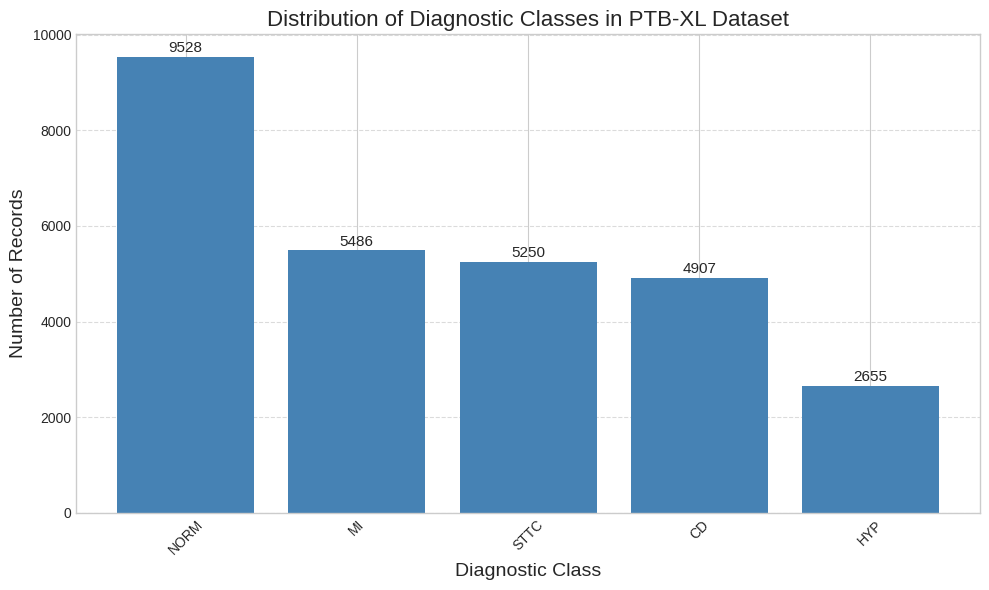

In [6]:
# === Diagnostic Class Distribution Visualization ===
class_counts = {}
for classes in df_meta['diagnostic_superclass']:
    for cls in classes:
        class_counts[cls] = class_counts.get(cls, 0) + 1

# Sort by frequency
class_items = sorted(class_counts.items(), key=lambda x: x[1], reverse=True)
classes, counts = zip(*class_items)

plt.figure(figsize=(10, 6))
bars = plt.bar(classes, counts, color='steelblue')
plt.title('Distribution of Diagnostic Classes in PTB-XL Dataset', fontsize=16)
plt.xlabel('Diagnostic Class', fontsize=14)
plt.ylabel('Number of Records', fontsize=14)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add counts above bars
for bar, count in zip(bars, counts):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 100,
             f"{count}", ha='center', fontsize=11)

plt.tight_layout()
plt.show()

## 🫀 MI Subtype Analysis (Clinical Specialization)

In [7]:
def get_mi_location(scp_codes):
    """
    Identify MI anatomical location from SCP codes

    Different MI locations have different clinical implications:
    - Anterior MI: LAD territory, high risk
    - Inferior MI: RCA territory, bradycardia risk
    - Lateral MI: LCX territory, specific lead changes
    """
    mi_locations = []

    # MI location codes based on coronary anatomy
    anterior_codes = ['AMI', 'ASMI']  # Anterior MI codes
    inferior_codes = ['IMI']  # Inferior MI codes
    lateral_codes = ['LMI', 'ALMI', 'ILMI', 'ASLMI']  # Lateral MI codes

    for code in scp_codes.keys():
        if code in anterior_codes:
            mi_locations.append('Anterior MI')
        if code in inferior_codes:
            mi_locations.append('Inferior MI')
        if code in lateral_codes:
            mi_locations.append('Lateral MI')

    return list(set(mi_locations))


# Apply MI localization analysis
df_meta['mi_location'] = df_meta['scp_codes'].apply(get_mi_location)

# Analyze MI location distribution
mi_location_counts = {}
for locations in df_meta['mi_location']:
    for location in locations:
        mi_location_counts[location] = mi_location_counts.get(location, 0) + 1

print("=== MI Anatomical Location Analysis ===")
if mi_location_counts:
    for location, count in mi_location_counts.items():
        print(f"{location}: {count:,} cases")
else:
    print("No specific MI location codes found in this dataset subset")

# Create essential columns for model training
essential_columns = [
    'age', 'sex', 'scp_codes', 'filename_hr', 'filename_lr', 'strat_fold',
    'diagnostic_superclass', 'mi_location'
]
df_cleaned = df_meta[essential_columns].copy()

print(f"\n=== Data Cleaning Summary ===")
print(f"Essential columns retained: {len(essential_columns)}")
print(f"Records after cleaning: {len(df_cleaned):,}")
print(f"Missing values in cleaned dataset: {df_cleaned.isnull().sum().sum()}")

=== MI Anatomical Location Analysis ===
Inferior MI: 2,685 cases
Lateral MI: 970 cases
Anterior MI: 2,717 cases

=== Data Cleaning Summary ===
Essential columns retained: 8
Records after cleaning: 21,837
Missing values in cleaned dataset: 0


## 📡 ECG Signal Loading and Validation

=== ECG Signal Loading Validation ===
✓ ECG signal loading successful
Signal shape: (1, 1000, 12)
Sampling rate: 100 Hz
Duration: 10.0 seconds
Number of leads: 12 (12-lead ECG)


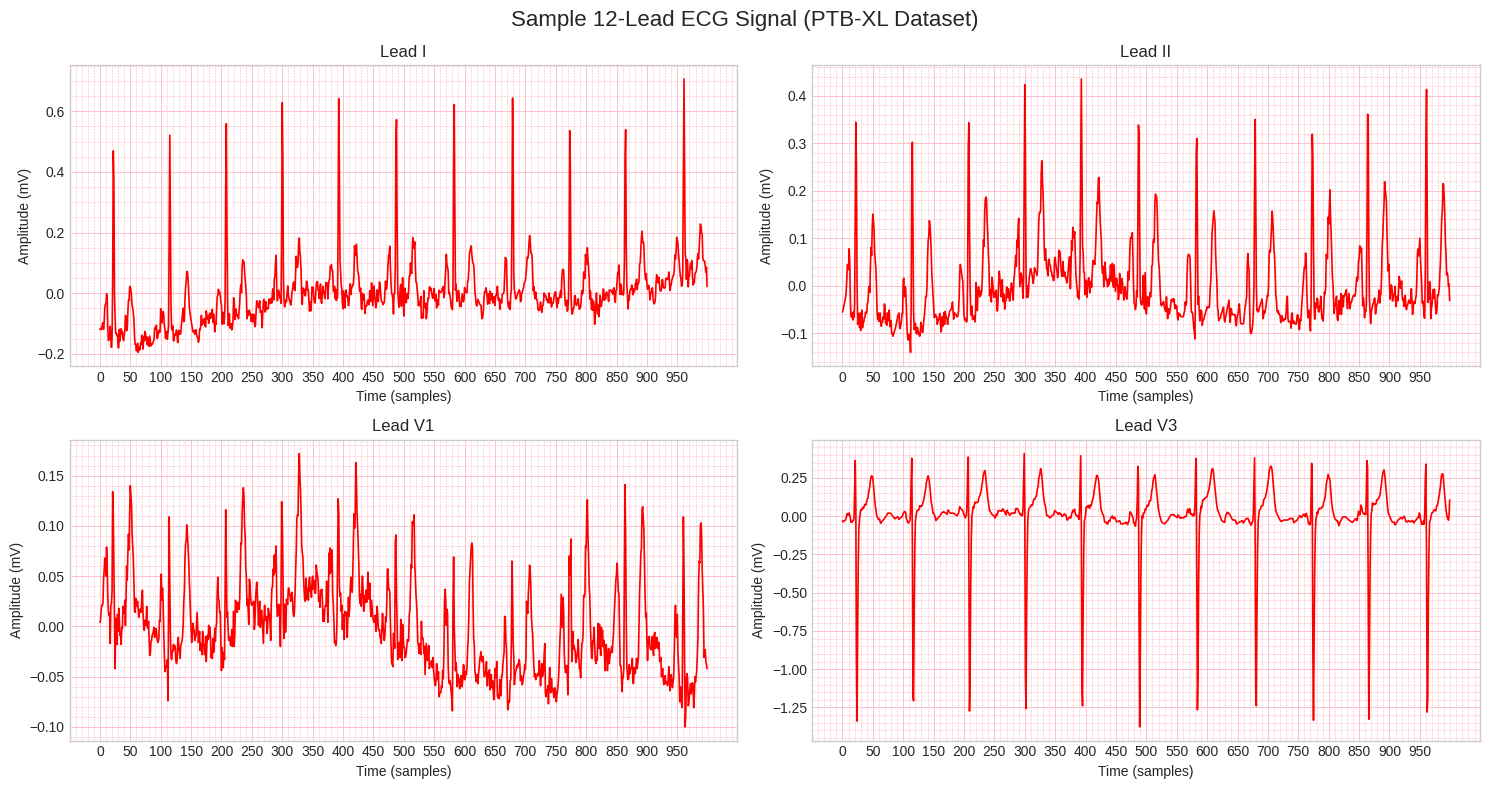

In [8]:
def load_raw_data(df, sampling_rate, data_dir):
    """
    Load ECG signals with clinical validation

    Args:
        df: DataFrame with file paths
        sampling_rate: 100 or 500 Hz
        data_dir: Base directory

    Returns:
        data: Array of ECG signals
        meta: Signal metadata
    """
    data = []
    for i, row in df.iterrows():
        if sampling_rate == 100:
            file_path = os.path.join(data_dir, row.filename_lr)
        else:
            file_path = os.path.join(data_dir, row.filename_hr)

        signal, meta = wfdb.rdsamp(file_path)
        data.append(signal)

    data = np.array(data)
    return data, meta


# Test signal loading with a single record
print("=== ECG Signal Loading Validation ===")
try:
    single_record = df_cleaned.iloc[[0]]
    sample_data, meta = load_raw_data(single_record, 100, data_dir)

    print(f"✓ ECG signal loading successful")
    print(f"Signal shape: {sample_data.shape}")
    print(f"Sampling rate: 100 Hz")
    print(f"Duration: {sample_data.shape[1] / 100:.1f} seconds")
    print(f"Number of leads: {sample_data.shape[2]} (12-lead ECG)")

    # Visualize sample ECG
    plt.figure(figsize=(15, 8))

    # Plot 4 key leads
    leads_to_show = [0, 1, 5, 7]  # Leads I, II, V1, V3
    lead_names = ['Lead I', 'Lead II', 'Lead V1', 'Lead V3']

    for i, lead_idx in enumerate(leads_to_show):
        ax = plt.subplot(2, 2, i + 1)

        signal = sample_data[0][:, lead_idx]

        # Plot ECG trace in red
        ax.plot(signal, color='red', linewidth=1.2)

        # Titles and labels
        ax.set_title(f'{lead_names[i]}', fontsize=12)
        ax.set_xlabel('Time (samples)')
        ax.set_ylabel('Amplitude (mV)')

        # ECG-style grid
        ax.set_xticks(np.arange(0, signal.shape[0], 50))  # big boxes (0.5s at 100Hz)
        ax.set_xticks(np.arange(0, signal.shape[0], 10), minor=True)  # small boxes (0.1s)

        ax.minorticks_on()
        ax.grid(which='major', color='pink', linestyle='-', linewidth=0.7)
        ax.grid(which='minor', color='lightpink', linestyle='--', linewidth=0.4)

    plt.suptitle('Sample 12-Lead ECG Signal (PTB-XL Dataset)', fontsize=16)
    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"✗ Error loading ECG data: {e}")

## 📋 Example ECG Signals by Diagnostic Class

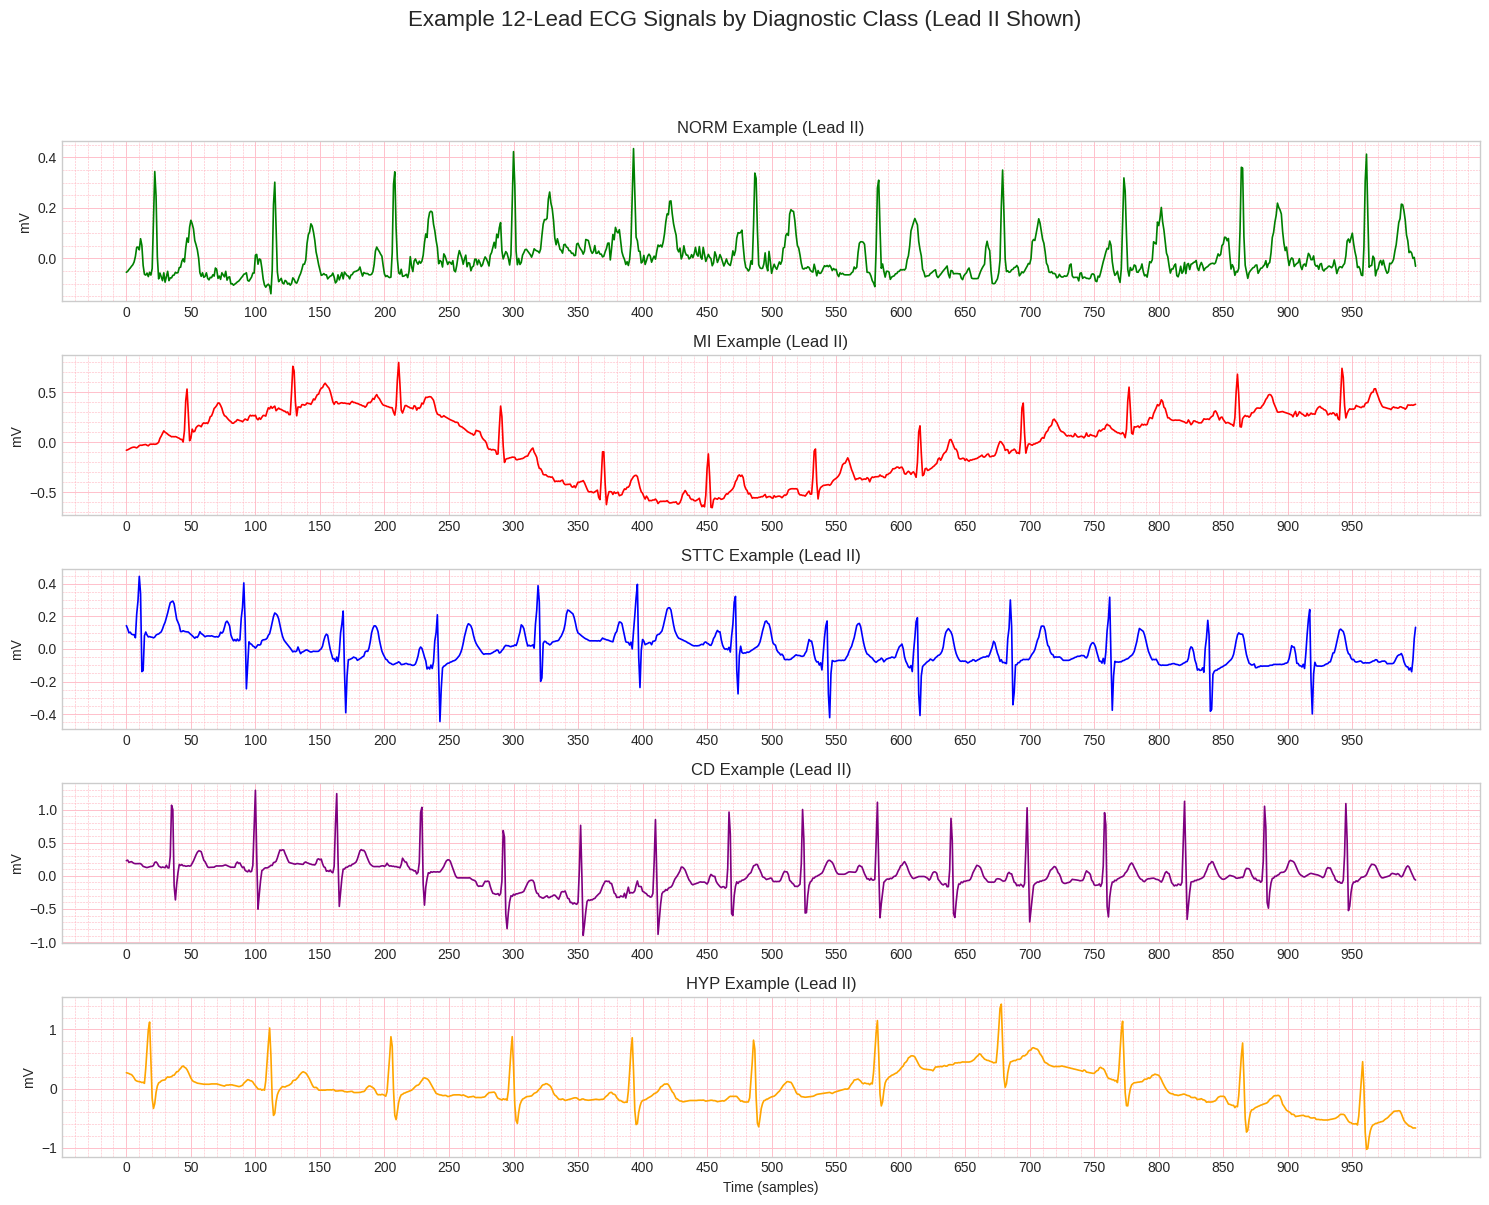

In [9]:
# === Example ECG Signals by Diagnostic Class ===

examples = {}
class_colors = {'NORM': 'green', 'MI': 'red', 'STTC': 'blue', 'CD': 'purple', 'HYP': 'orange'}

# Get one representative example per class
for cls in ['NORM', 'MI', 'STTC', 'CD', 'HYP']:
    class_examples = df_meta[df_meta['diagnostic_superclass'].apply(lambda x: cls in x)].iloc[:1]
    if len(class_examples) > 0:
        examples[cls] = class_examples

plt.figure(figsize=(15, 12))
from matplotlib.gridspec import GridSpec

gs = GridSpec(5, 1, figure=plt.gcf())  # one row per class

row = 0
for cls, examples_df in examples.items():
    for _, example in examples_df.iterrows():
        # Load ECG
        signal_data, _ = load_raw_data(pd.DataFrame([example]), 100, data_dir)
        ecg_signal = signal_data[0][:, 1]  # Lead II (standard for rhythm analysis)

        ax = plt.subplot(gs[row, 0])
        ax.plot(ecg_signal, color=class_colors[cls], linewidth=1.2)

        # ECG-style grid
        ax.set_xticks(np.arange(0, ecg_signal.shape[0], 50))  # 0.5s major boxes
        ax.set_xticks(np.arange(0, ecg_signal.shape[0], 10), minor=True)  # 0.1s minor boxes
        ax.minorticks_on()
        ax.grid(which='major', color='pink', linestyle='-', linewidth=0.7)
        ax.grid(which='minor', color='lightpink', linestyle='--', linewidth=0.4)

        ax.set_title(f"{cls} Example (Lead II)", fontsize=12)
        ax.set_ylabel('mV')
        if row == len(examples) - 1:
            ax.set_xlabel('Time (samples)')

    row += 1

plt.suptitle(
    'Example 12-Lead ECG Signals by Diagnostic Class (Lead II Shown)',
    fontsize=16,
    y=1
)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()